<a href="https://colab.research.google.com/github/maskmo/Take-Home-Problems/blob/main/take_at_home_problem_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Set 1 - Take at home (50 Points)

## PS1.A (15 points)


![](images/autoencoder.png)

Design a neural system that will receive an input image from the CIFAR10 dataset and it will _reconstruct it_ at the output.

To do so the encoder must compress the input image into a vector of size $d$ and the decoder must reconstruct the image from the vector of size $d$.

The encoder spatial dimensions of its output feature maps will determined by the input height or width (i), kernel (k), padding (p), and stride (s), producing the output feature map (o) size that is given by

$$o = \frac{i-k+2p}{s}+1$$

The decoder must make use of a number of _transposed convolutional_ layers - each successively upsamples its input feature map. The operation is the inverse of the earlier question on representing convolution as a matrix by vector product:

$$x = C^T y$$

For a given size of the input (i), kernel (k), padding (p), and stride (s), the size of the output feature map (o) generated is given by

$$o = s(i-1)+k-2p$$

Ultimately the size of the input image is produced at the output of the decoder and this would allow the comparison of the original input image and the decoded image $\tilde x$.  

Your design should include all dimensions of the encoder and decoder CNNs including the number of layers, number of filters and spatial dimensions, the activation functions, the loss function, the optimizer. You need to expose this information via the API (you can use any framework you know).



In [48]:
#importing necessary libraries for convolutional autoencoder
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.regularizers import L2

In [10]:
#loading the datta from keras and printing to verify dimensions

cifar10 = tf.keras.datasets.cifar10
(x_train, _), (x_test, _) = cifar10.load_data()
print(x_train.shape)

(50000, 32, 32, 3)


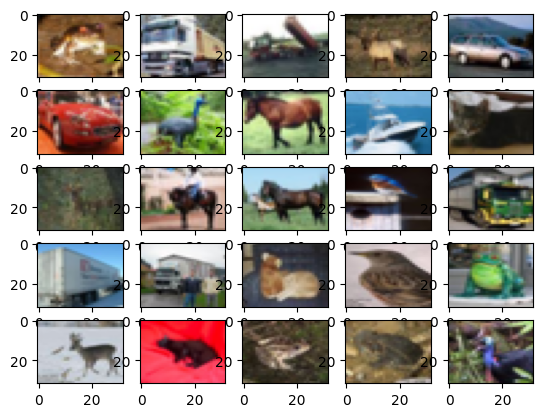

In [11]:
#looking at the data to see what it is

fig, ax = plt.subplots(5, 5)
k = 0

for i in range(5):
    for j in range(5):
        ax[i][j].imshow(x_train[k], aspect='auto')
        k += 1

plt.show()

In [12]:
#normalizing the data and reshaping to a one dimensional 32*32*3 length array to preserve data but make the first NN simpler

def process(data):
  data = data/255.0                     #normalizing data points
  data = data.reshape(len(data), 3072)  #converting to 1d array without losing entries
  return data

train = process(x_train)

In [13]:
#trying out a imple autoendocer to practice

from keras.engine.training import optimizer
# type here the python model of the autoencoder

input_dim, output_dim = 3072, 3072
encode_dim = 300
hidden_dim = 768

encoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim,), name ="INPUT"),
    tf.keras.layers.Dense(hidden_dim, activation="relu", name = "HIDDEN_1")
])

decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(encode_dim, activation="relu", name = "CODE"),
    tf.keras.layers.Dense(hidden_dim, activation="relu", name = "HIDDEN_2"),
    tf.keras.layers.Dense(output_dim, activation="relu", name = "OUTPUT")

])

AE = tf.keras.Sequential([encoder, decoder])
AE.compile(optimizer="sgd", loss = "mse")

In [14]:
#visualizing data again with a more flexible function (print as many photos as desired)

def show_images(data, n=10, title=""):
  plt.figure(figsize=(15,5))
  for i in range(n):
    ax = plt.subplot(2,n,i+1)
    plt.imshow(tf.keras.utils.array_to_img(data[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.title(title, fontsize = 20)

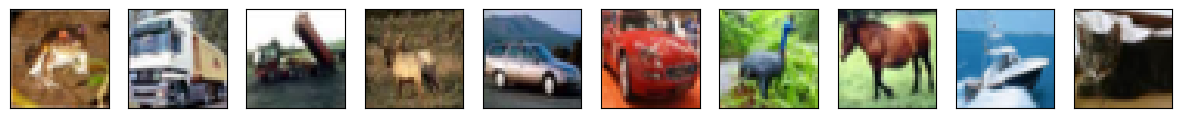

In [15]:
show_images(x_train)

In [16]:
#Creating the convolutonal neural network without sequential for the model summary that helps with making sure the input and output dimensions match
#padding remains "same" for each layer to easily keeo track of dimensions
input_layer = Input(shape = (32,32,3), name = "INPUT")                  #Input layer, no dimension change
x =Conv2D(16, (3,3), padding="same", activation="relu")(input_layer)    #convolution layer with 16 3*3 filters that halves dimensions but increases depth to size 16
x =MaxPooling2D(pool_size=(2,2))(x)                                     #max pooling layer that halves the width and height of dimensions but preserves the depth
x =Conv2D(8, (3,3), padding="same", activation="relu")(x)               #convolution layer with 8 3*3 filters that halves dimensions but changes depth to size 8
x =MaxPooling2D(pool_size=(2,2))(x)                                     #max pooling layer that halves the width and height of dimensions but preserves the depth
x =Conv2D(8, (3,3), padding="same", activation="relu")(x)               #convolution layer with 8 3*3 filters that halves dimensions but keeps depth to size 8


code_layer =MaxPooling2D((2,2), name = "CODE")(x)                       #max pooling code layer that halves dimensions but keeps depth


x =UpSampling2D((2,2))(code_layer)                                      #upsampling layer that doubles height and width dimensions (almost like a reverse max pooling layer)
x =Conv2DTranspose(8,(3,3),padding="same", activation="relu")(x)        #transpose convolution that doubles height and width dimensions with preserving depth
x =UpSampling2D((2,2))(x)                                               #upsampling layer that doubles height and width dimensions (almost like a reverse max pooling layer)
x =Conv2DTranspose(16,(3,3),padding="same")(x)                          #transpose convolution that doubles height and width dimensions with preserving depth
x =UpSampling2D((2,2))(x)                                               #upsampling layer that doubles height and width dimensions (almost like a reverse max pooling layer)
output_layer =Conv2D(3, (3,3), padding = "same", name = "OUTPUT")(x)    #output layer with three filters to produce a 3rd dimension of size 3 to translate photo colors

old_ae = Model(input_layer, output_layer)                               #creating the model

In [17]:
#compiling the model with adam optimizer and mean square error loss, printing the summary to verify dimensions at each step

old_ae.compile(optimizer="adam", loss="mse")
old_ae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 8)         1160      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 8)          0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 8)           584   

In [18]:
old_ae.fit(x_train, x_train)

1563/1563 [==============================] - 19s 5ms/step - loss: 1406.1793


In [19]:
#taking the last convolutional autoencoder a bit further by adding a dense layer in the middle as the code layer to match the kind of convae we learned about in class
input_layer = Input(shape = (32,32,3), name = "INPUT")
x =Conv2D(16, (3,3), padding="same", activation="relu")(input_layer)
x =MaxPooling2D(pool_size=(2,2))(x)
x =Conv2D(8, (3,3), padding="same", activation="relu")(x)
x =MaxPooling2D(pool_size=(2,2))(x)
x =Conv2D(8, (3,3), padding="same", activation="relu")(x)
x =MaxPooling2D((2,2), name = "CODE")(x)


dense =Dense(4*4*8, name = "DENSE")(x)


x =UpSampling2D((2,2))(dense)
x =Conv2DTranspose(8,(3,3),padding="same", activation="relu")(x)
x =UpSampling2D((2,2))(x)
x =Conv2DTranspose(16,(3,3),padding="same")(x)
x =UpSampling2D((2,2))(x)
output_layer =Conv2D(3, (3,3), padding = "same", name = "OUTPUT")(x)

old_ae = Model(input_layer, output_layer)

old_ae.compile(optimizer="adam", loss="mse")
old_ae.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 8)         1160      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 8, 8, 8)          0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 8, 8)           584 

In [20]:
#fitting the training data
old_ae.fit(x_train,x_train)

1563/1563 [==============================] - 12s 6ms/step - loss: 1277.0596


In [21]:
#creating a sequential encoder for ease of use using all the same layers as the previous encoder
conv_encoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (32,32,3), name = "INPUT"),
    tf.keras.layers.Conv2D(16, (3,3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(8, (3,3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(8, (3,3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),
])

conv_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(4*4*8, name ="CODE"),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2DTranspose(8,(3,3),padding="same", activation="relu"),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2DTranspose(8,(3,3),padding="same", activation="relu"),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(3, (3,3), padding = "same", name = "OUTPUT")
])

new_ae = tf.keras.Sequential([conv_encoder,conv_decoder])
new_ae.compile(optimizer='adam', loss='mse')
# please note that elements of the model that are typed in without any explanation will receive 0 points

# PS1.B (15 points)

Train your PS1.A autoencoder  and produce the validation or test loss as a number of epochs. Make sure you explain any preprocessing stages and ensure you show the hyperparameter tuning process in your code.



In [22]:
#fitting the newest autoencoder to the training data
new_ae.fit(x_train, x_train, epochs = 15)

Epoch 1/15
1563/1563 [==============================] - 12s 6ms/step - loss: 1431.3347
Epoch 2/15
1563/1563 [==============================] - 9s 6ms/step - loss: 919.8075
Epoch 3/15
1563/1563 [==============================] - 11s 7ms/step - loss: 836.3159
Epoch 4/15
1563/1563 [==============================] - 9s 6ms/step - loss: 802.8700
Epoch 5/15
1563/1563 [==============================] - 9s 6ms/step - loss: 785.6421
Epoch 6/15
1563/1563 [==============================] - 9s 6ms/step - loss: 776.4171
Epoch 7/15
1563/1563 [==============================] - 9s 6ms/step - loss: 766.7718
Epoch 8/15
1563/1563 [==============================] - 9s 6ms/step - loss: 760.6378
Epoch 9/15
1563/1563 [==============================] - 9s 6ms/step - loss: 754.8445
Epoch 10/15
1563/1563 [==============================] - 9s 6ms/step - loss: 750.8407
Epoch 11/15
1563/1563 [==============================] - 9s 6ms/step - loss: 746.8988
Epoch 12/15
1563/1563 [==============================] - 9s 

313/313 [==============================] - 1s 2ms/step


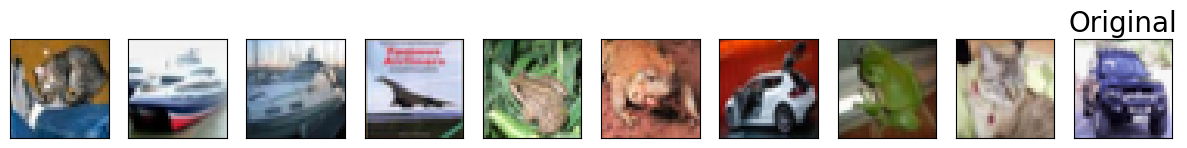

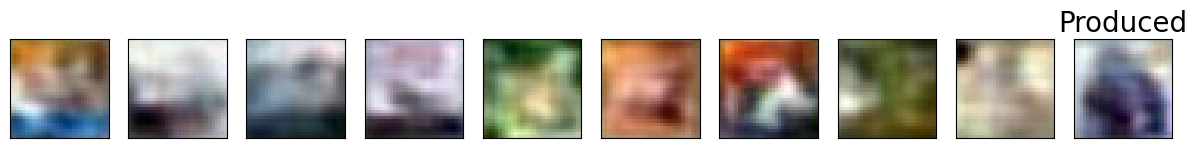

In [43]:
show_images(x_test, title ="Original")
show_images(new_ae.predict(x_test), title = "Produced")

In [50]:
#hyperparameter tuning
opt_2 = Adam(learning_rate=0.001)

conv_encoder2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (32,32,3), name = "INPUT"),
    tf.keras.layers.Conv2D(16, (3,3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(8, (3,3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(8, (3,3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dense(4*4*8, activation ="relu", kernel_regularizer=L2(0.001)),   #using relu activation for the dense layers and using l2 regularization
    tf.keras.layers.Dropout(0.05),                                                    #using a dropout of 5%
])

conv_decoder2 = tf.keras.Sequential([
    tf.keras.layers.Dense(4*4*8, activation ="relu", kernel_regularizer=L2(0.001)),   #using relu activation for the dense layers and using l2 regularization
    tf.keras.layers.Dropout(0.05),                                                    #using a dropout of 5%
    tf.keras.layers.Dense(4*4*8, activation ="relu", kernel_regularizer=L2(0.001)),   #using relu activation for the dense layers and using l2 regularization
    tf.keras.layers.Dropout(0.05),                                                    #using a dropout of 5%
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2DTranspose(8,(3,3),padding="same", activation="relu"),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2DTranspose(8,(3,3),padding="same", activation="relu"),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(3, (3,3), padding = "same", name = "OUTPUT")
])

new_ae2 = tf.keras.Sequential([conv_encoder2,conv_decoder2])
new_ae2.compile(optimizer=opt_2, loss='mse')                                          #including the customized learning rate and using mean squared error since this is a regression and not a classification preblem

In [52]:
#The tuning was fruitful the loss is lower on the training data although the validation loss remained somewhat constant
new_ae2.fit(x_train, x_train, epochs = 15, validation_data = (x_test, x_test))

Epoch 1/15
1563/1563 [==============================] - 11s 7ms/step - loss: 701.3113 - val_loss: 781.6589
Epoch 2/15
1563/1563 [==============================] - 11s 7ms/step - loss: 698.5791 - val_loss: 793.4496
Epoch 3/15
1563/1563 [==============================] - 10s 6ms/step - loss: 696.1238 - val_loss: 925.9515
Epoch 4/15
1563/1563 [==============================] - 10s 6ms/step - loss: 694.3313 - val_loss: 758.2670
Epoch 5/15
1563/1563 [==============================] - 13s 8ms/step - loss: 691.5207 - val_loss: 828.4432
Epoch 6/15
1563/1563 [==============================] - 11s 7ms/step - loss: 690.0123 - val_loss: 772.4529
Epoch 7/15
1563/1563 [==============================] - 13s 8ms/step - loss: 688.0485 - val_loss: 855.6786
Epoch 8/15
1563/1563 [==============================] - 11s 7ms/step - loss: 686.8426 - val_loss: 814.6806
Epoch 9/15
1563/1563 [==============================] - 10s 7ms/step - loss: 685.6875 - val_loss: 843.1261
Epoch 10/15
1563/1563 [==============

313/313 [==============================] - 1s 3ms/step


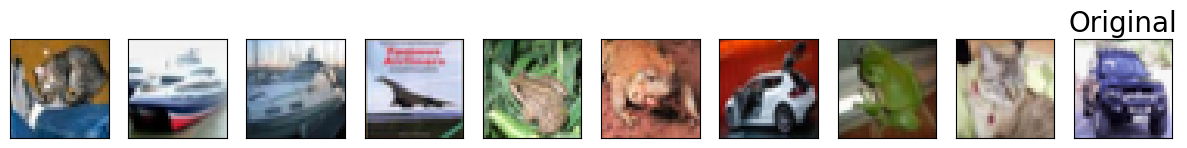

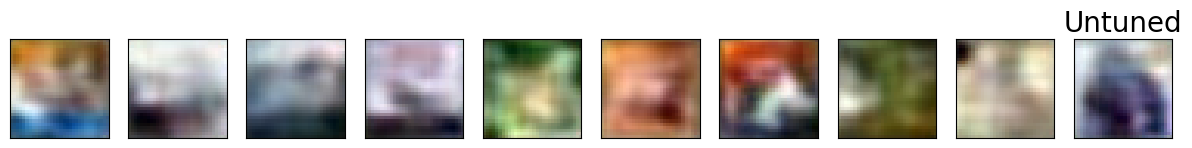

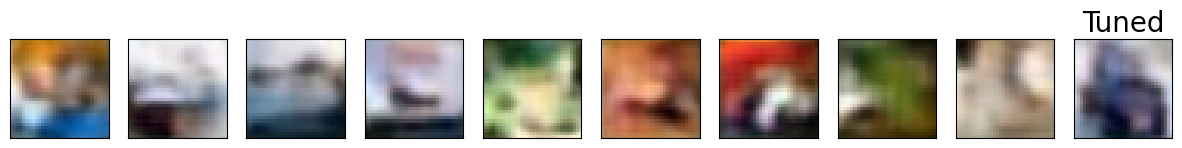

In [54]:
#there are slight differences in definition and vibrance/color that demonstrate the superiority of the tuned model
show_images(x_test, title ="Original")
show_images(new_ae.predict(x_test), title = "Untuned")
show_images(new_ae2.predict(x_test), title = "Tuned")

# PS1.C (20 points)

Add zero-mean Gaussian noise with variance that ranges from 0 to 1 to the images and repeat the training exercise comparing results with PS1.B and explaining why adding noise is a good idea.

Explain here

This noise is a good idea to produce images that are like the training data but not replicas. This type of generative machine learning has many applications such as LLMs that can aid in producing original or personal answers to questions/prompts, or image generators that can create art for the purpose of graphic design.

In [23]:
#creating a sampling class that samples datapoints from a specified mean and standard deviation using the method of taking the log variance to increase loss function calculation efficiency
class Sampling(tf.keras.layers.Layer):
  def call(self, inputs):
    mean, log_var = inputs
    return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

In [41]:
input_layer = Input(shape = (32,32,3), name = "INPUT")
x =Conv2D(16, (3,3), padding="same", activation="relu")(input_layer)
x =MaxPooling2D(pool_size=(2,2))(x)
x =Conv2D(8, (3,3), padding="same", activation="relu")(x)
x =MaxPooling2D(pool_size=(2,2))(x)
x =Conv2D(8, (3,3), padding="same", activation="relu")(x)
x =MaxPooling2D((2,2), name = "CODE")(x)
codings_mean =Dense(8*8*8)(x)                                                                             #defining a dense layer to be the layer that will define the mean (making sure the mean is centered about the models datapoints)
codings_log_var =Dense(8*8*8)(x)                                                                          #defining a dense layer to be the layer that will define the log variance
codings = Sampling()([codings_mean, codings_log_var])                                                     #defining a sampling layer based on the defined mean and variance
variational_encoder = Model(inputs = [input_layer], outputs = [codings_mean, codings_log_var, codings])   #defining the input and outputs of the variational autoencoder. The outputs are the mean, variance, and the normally sampled datapoints about the previous dense layer

decoder_inputs = Input(shape=(4,4,512))
x =Dense(4*4*8)(decoder_inputs)
x =UpSampling2D((2,2))(x)
x =Conv2DTranspose(8,(3,3),padding="same", activation="relu")(x)
x =UpSampling2D((2,2))(x)
x =Conv2DTranspose(16,(3,3),padding="same")(x)
x =UpSampling2D((2,2))(x)
output_layer =Conv2D(3, (3,3), padding = "same", name = "OUTPUT")(x)
variational_decoder = Model(inputs = [decoder_inputs], outputs=[output_layer])                            #the decoder is defined seperately from the encoder to be able to define the inputs as the normally sampled inputs and not the regular dense layer we've seen before

_, _, codings = variational_encoder(input_layer)                                                          #the normally sampled data added to the original layer are taken from the encoderto be used as inputs to the decoder
reconstructions = variational_decoder(codings)                                                            #the outputs are defined as the decoder with inputs from the variational data
variational_ae = Model(inputs = [input_layer], outputs = [reconstructions])                               #the encoder is defined

latent_loss = -0.5 * tf.reduce_sum( 1+codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean), axis = -1 )  #adjusting the loss function to account for the variance introduced into the latent variables as gaussian variation
variational_ae.add_loss(tf.reduce_mean(latent_loss/784.0))

variational_ae.summary()
variational_ae.compile(optimizer="nadam", loss="mse")

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 INPUT (InputLayer)             [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 model_15 (Functional)          [(None, 4, 4, 512),  11408       ['INPUT[0][0]']                  
                                 (None, 4, 4, 512),                                               
                                 (None, 4, 4, 512)]                                               
                                                                                                  
 model_16 (Functional)          (None, 32, 32, 3)    76491       ['model_15[0][2]']               
                                                                                           

In [42]:
variational_ae.fit(x_train, x_train, epochs = 15)

Epoch 1/15
1563/1563 [==============================] - 20s 10ms/step - loss: 1867.1205
Epoch 2/15
1563/1563 [==============================] - 22s 14ms/step - loss: 1097.6682
Epoch 3/15
1563/1563 [==============================] - 25s 16ms/step - loss: 987.2165
Epoch 4/15
1563/1563 [==============================] - 19s 12ms/step - loss: 932.0916
Epoch 5/15
1563/1563 [==============================] - 15s 10ms/step - loss: 902.7778
Epoch 6/15
1563/1563 [==============================] - 15s 10ms/step - loss: 878.7430
Epoch 7/15
1563/1563 [==============================] - 15s 10ms/step - loss: 860.4679
Epoch 8/15
1563/1563 [==============================] - 16s 10ms/step - loss: 847.3138
Epoch 9/15
1563/1563 [==============================] - 15s 10ms/step - loss: 838.6494
Epoch 10/15
1563/1563 [==============================] - 15s 10ms/step - loss: 827.4613
Epoch 11/15
1563/1563 [==============================] - 16s 10ms/step - loss: 817.5088
Epoch 12/15
1563/1563 [================

313/313 [==============================] - 1s 3ms/step


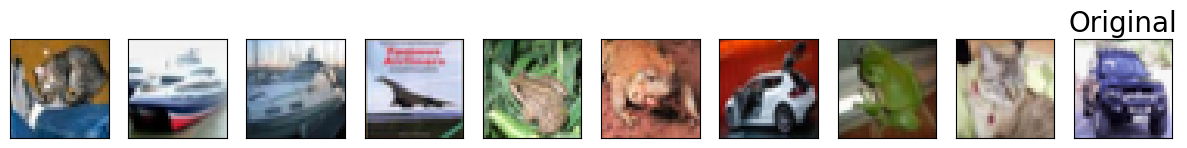

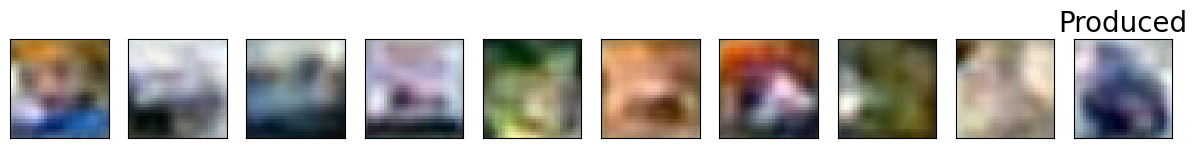

In [44]:
#displaying the before and after of the images put through the variational autoencoder
show_images(x_test, title = "Original")
show_images(variational_ae.predict(x_test), title = "Produced")